# This notebook will plot expression of gene set in stages and clusters

## Imports

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony
import random
np.random.seed(0)
random.seed(0)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sc.settings.verbosity = 0


## Loading individual datasets

In [5]:
def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [6]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [8]:
#loading and concatenating files
stages = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , stages)



In [9]:
counts = concat_for_harmony(adatas, stages)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [10]:
def adata_hvg(adata, N_genes = 1000):
    print(adata.obs.stage[0])
    counts = pd.DataFrame(data = adata.X.todense(), 
                          index = adata.obs_names,
                          columns = adata.var_names)
    norm_df = harmony.utils.normalize_counts(counts)
    hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=N_genes)
    return hvg_genes.tolist()

In [11]:
def flatten(ls):
    return [x for y in ls for x in y]
hvg_genes_per_data = list(set(flatten([adata_hvg(x, N_genes = 500) for x in adatas])))

st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27


In [12]:
len(hvg_genes_per_data)

3906

In [13]:
#Cell type colors from integrated annotation
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [15]:
#Setting up stage and cluster annotation

In [16]:
tp = pd.Series(index=data_df.index)
for t in stages:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [17]:
import pickle
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [32]:
#Remove non-informative gene names
#data = data_df.copy()
# for all genes


data = norm_df.loc[:,hvg_genes_per_data]
genes_sub = [x for x in data.columns if 'LOC' not in x]
genes_sub = [x for x in genes_sub if 'Xetrov' not in x]
genes_sub = [x for x in genes_sub if 'Xelaev' not in x]
genes_sub = [x for x in genes_sub if 'MGC' not in x]
genes_sub = [x for x in genes_sub if '|loc' not in x]
print('Subsetting to {} genes'.format(len(genes_sub)))
data = data.loc[:,genes_sub]

Subsetting to 2979 genes


In [34]:
#Load affinity matrix
with open('../intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [35]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [36]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [37]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

# HVG's over stages

In [91]:
from Heatmaps import two_step_order

In [25]:

data['Stages'] = tp
means = data.groupby('Stages').mean().T
binar = means.apply(np.argmax, axis = 1)
binar = pd.crosstab(binar.index, binar.values)
binar.columns = identifiers

In [27]:
from Heatmaps import two_step_order

In [28]:
two_order, stage_genes = two_step_order(binar, means, stages)

In [23]:
dfs = []
for i in stage_genes.keys():
    dfs.append(pd.DataFrame([stage_genes[i].tolist(), 
                  [i]*len(stage_genes[i])]))
pd.concat(dfs, axis = 1).T.to_csv('Heatmap_markers/Gene_lists_bounds/HVG_by_stage.tsv', sep = '\t')

In [29]:
to_plot = means.loc[two_order]

In [30]:
r_order = tp.unique()

In [31]:
c_order = [x for y in [tp[tp == i].index.tolist() for i in r_order] for x in y]

In [32]:
imp_sub = imp_df.loc[c_order,to_plot.index]

In [33]:
stage_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

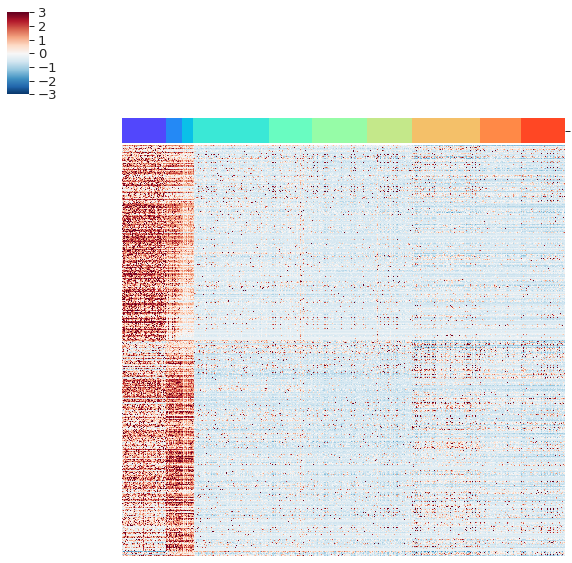

In [315]:
#Save first half of plot, too large for saving as one 
sns.clustermap(imp_sub.iloc[:,:1500].T, cmap = 'RdBu_r', row_cluster=False, col_cluster=False, 
               z_score=0,
               vmin = -3, 
               vmax = 3,  
               center = 0,
               col_colors=tp.map(stage_colors),
               yticklabels=False,
               xticklabels=False,
               rasterized = True,
              linewidths = 0)

plt.savefig('scHeatmap_imputed_top_stage.pdf')

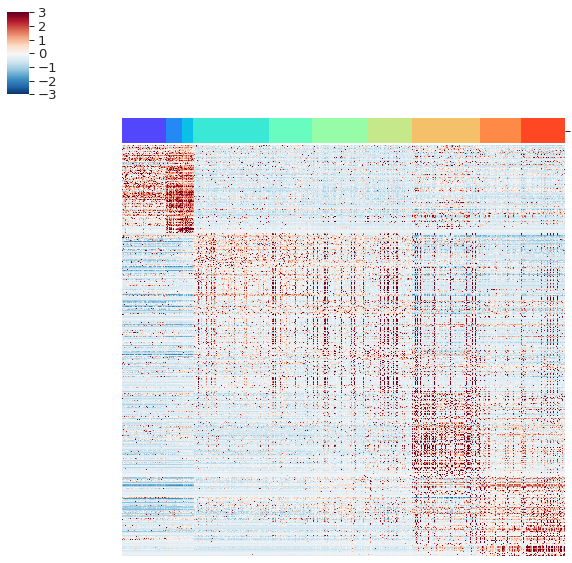

In [317]:
#Save second half of plot
sns.clustermap(imp_sub.iloc[:,1500:].T, cmap = 'RdBu_r', row_cluster=False, col_cluster=False, 
               z_score=0,
               vmin = -3, 
               vmax = 3,  
               center = 0,
               col_colors=tp.map(stage_colors),
               yticklabels=False,
               xticklabels=False,
               rasterized = True,
              linewidths = 0)
plt.savefig('scHeatmap_imputed_bottom_stage.pdf')


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


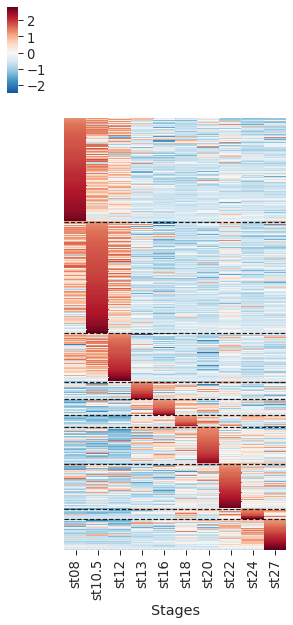

In [35]:
#Figure with gene names
#cm = sns.clustermap(to_plot, 
#                    z_score=0,
#                    col_cluster = False, 
#                    row_cluster = False, 
#                    cmap = 'RdBu_r',
#                    figsize = (5,10), 
#                    rasterized=True,
#                   #yticklabels=False,
#                    center=0,
#                    yticklabels=[x.split('|')[1] for x in to_plot.index]
#                   )
#lines = [len(stage_genes[x]) for x in stage_genes.keys()]
#lines = np.cumsum(lines)
#cm.ax_heatmap.hlines(lines, *cm.ax_heatmap.get_xlim(), linestyles='dashed')
#hm = cm.ax_heatmap.get_position()
#plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=0.7)

#plt.savefig('Heatmap_markers/heatmap_stages_gene_names.pdf')

cm = sns.clustermap(to_plot, 
                    z_score=0,
                    col_cluster = False, 
                    row_cluster = False, 
                    cmap = 'RdBu_r',
                    figsize = (5,10), 
                    rasterized=True,
                    yticklabels=False,
                    center=0
                   )
lines = [len(stage_genes[x]) for x in stage_genes.keys()]
lines = np.cumsum(lines)
cm.ax_heatmap.hlines(lines, *cm.ax_heatmap.get_xlim(), linestyles='dashed')
#plt.savefig('Heatmap_markers/heatmap_stages.pdf')


In [36]:
from Heatmaps import map_to_human

In [45]:
for i in stage_genes.keys():
    shortened = [x[1] for x in stage_genes[i].str.split('|')]
    #If mapping to human orthologs
    pd.Series(map_to_human(shortened)).to_csv('Heatmap_markers/human_heatmap_markers_{}.tsv'.format(i), sep = '\t', index = False)


Mapped 87.53501400560224 % to human orthologs
Mapped 90.14267185473412 % to human orthologs
Mapped 87.38738738738738 % to human orthologs
Mapped 89.07563025210085 % to human orthologs
Mapped 85.84070796460178 % to human orthologs
Mapped 93.58974358974359 % to human orthologs
Mapped 89.41176470588236 % to human orthologs
Mapped 85.25641025641025 % to human orthologs
Mapped 80.55555555555556 % to human orthologs
Mapped 86.79245283018868 % to human orthologs


In [37]:
pd.Series([x.split('|')[1] for x in to_plot.index]).to_csv('Heatmap_markers/heatmap_markers_stages.tsv', sep = '\t')

# HVG's over Clusters

In [123]:
data['cluster'] = clusters
means = data.groupby('cluster').mean().T
binar = means.apply(np.argmax, axis = 1)
binar = pd.crosstab(binar.index, binar.values)
r_order = colors.sort_values('clust_order').org_clust.values.tolist()
row_order = binar.sort_values(by=r_order, ascending = False).index.tolist()

In [124]:
two_order, cluster_genes = two_step_order(binar, means, r_order)

In [140]:
dfs = []
for i in cluster_genes.keys():
    dfs.append(pd.DataFrame([cluster_genes[i].tolist(), 
                  [i]*len(cluster_genes[i])]))
pd.concat(dfs, axis = 1).T.to_csv('Heatmap_markers/Gene_lists_bounds/HVG_by_cluster.tsv', sep = '\t')

In [126]:
col = colors.copy()
col.columns = ['Clusters', 'org_clust', 'clust_order']

In [127]:
#Save rownames to file

to_plot = means.loc[two_order, r_order]
#pd.Series([x.split('|')[1] for x in to_plot.index]).to_csv('Heatmap_markers/Clusters_gene_order.tsv', sep = '\t')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


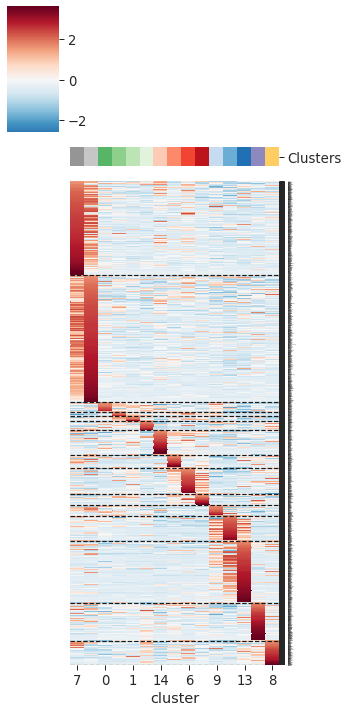

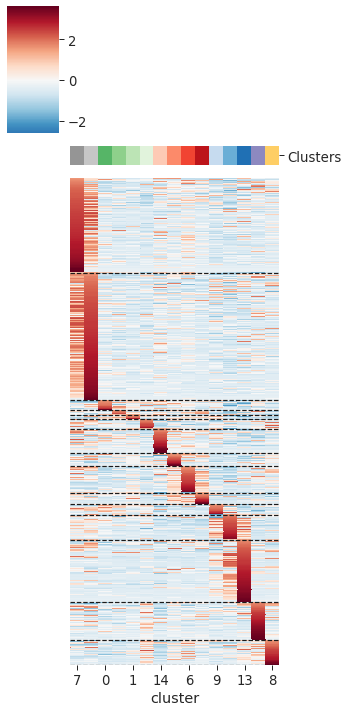

In [129]:

cm = sns.clustermap(to_plot, 
                    z_score=0,
                    col_cluster = False, 
                    row_cluster = False, 
                    cmap = 'RdBu_r',
                    figsize = (5,10), 
                    rasterized=True,
                    #yticklabels=False, 
                    yticklabels=[x.split('|')[1] for x in to_plot.index], 
                    col_colors = col.Clusters,
                    center = 0
                   )

lines = [len(cluster_genes[x]) for x in cluster_genes.keys()]
lines = np.cumsum(lines)
cm.ax_heatmap.hlines(lines, *cm.ax_heatmap.get_xlim(), linestyles='dashed')

hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=0.7)
plt.tight_layout()
#plt.savefig('Heatmap_markers/heatmap_clusters_gene_names.pdf')

cm = sns.clustermap(to_plot, 
                    z_score=0,
                    col_cluster = False, 
                    row_cluster = False, 
                    cmap = 'RdBu_r',
                    figsize = (5,10), 
                    rasterized=True,
                    yticklabels=False, 
                    col_colors = col.Clusters,
                    center = 0
                   )

lines = [len(cluster_genes[x]) for x in cluster_genes.keys()]
lines = np.cumsum(lines)
cm.ax_heatmap.hlines(lines, *cm.ax_heatmap.get_xlim(), linestyles='dashed')

plt.tight_layout()
#plt.savefig('Heatmap_markers/heatmap_clusters.pdf')





In [159]:
r_order = colors.sort_values('clust_order').org_clust.values.tolist()

In [160]:
c_order = [x for y in [clusters[clusters == i].index.tolist() for i in r_order] for x in y]

In [111]:
imp_sub = imp_df.loc[c_order,to_plot.index]

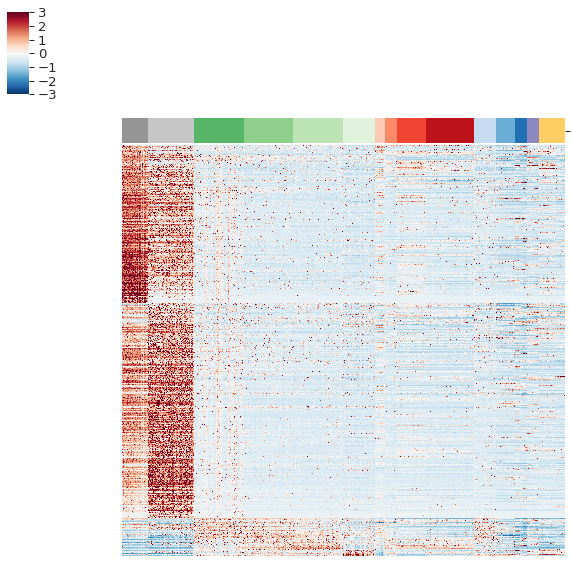

In [126]:
sns.clustermap(imp_sub.iloc[:,:1500].T, cmap = 'RdBu_r', row_cluster=False, col_cluster=False, 
               z_score=0,
               vmin = -3, 
               vmax = 3,  
               center = 0,
               col_colors=clusters.map(colors.color),
               yticklabels=False,
               xticklabels=False,
               rasterized = True,
              linewidths = 0)

plt.savefig('scHeatmap_imputed_top.pdf')

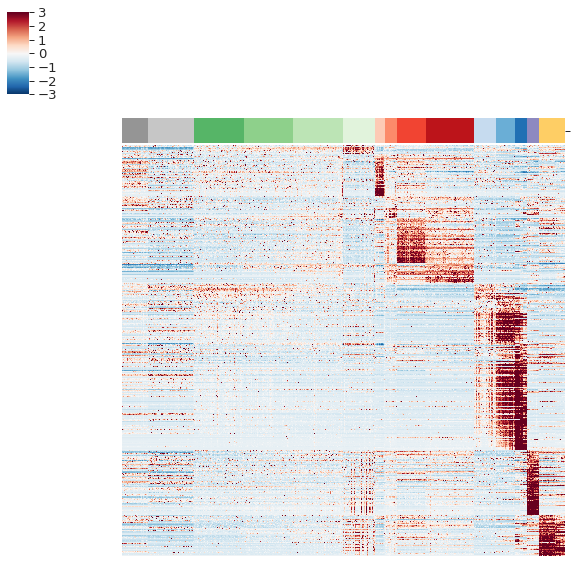

In [127]:
sns.clustermap(imp_sub.iloc[:,1500:].T, cmap = 'RdBu_r', row_cluster=False, col_cluster=False, 
               z_score=0,
               vmin = -3, 
               vmax = 3,  
               center = 0,
               col_colors=clusters.map(colors.color),
               yticklabels=False,
               xticklabels=False,
               rasterized = True,
              linewidths = 0)
plt.savefig('scHeatmap_imputed_bottom.pdf')


In [34]:
for i in cluster_genes.keys():
    shortened = [x[1] for x in cluster_genes[i].str.split('|')]
    pd.Series(map_to_human(shortened)).to_csv('Heatmap_markers/human_heatmap_markers_{}.tsv'.format(i), sep = '\t', index = False)


Mapped 89.65517241379311 % to human orthologs
Mapped 88.36317135549872 % to human orthologs
Mapped 86.66666666666667 % to human orthologs
Mapped 85.71428571428571 % to human orthologs
Mapped 89.65517241379311 % to human orthologs
Mapped 85.71428571428571 % to human orthologs
Mapped 89.40397350993378 % to human orthologs
Mapped 88.75 % to human orthologs
Mapped 83.85093167701864 % to human orthologs
Mapped 87.14285714285714 % to human orthologs
Mapped 85.9375 % to human orthologs
Mapped 84.4155844155844 % to human orthologs
Mapped 86.45833333333334 % to human orthologs
Mapped 91.84549356223177 % to human orthologs
Mapped 87.75510204081633 % to human orthologs


In [38]:
pd.Series(map_to_human([x.split('|')[1] for x in counts.columns])).to_csv('Heatmap_markers/background.tsv', sep = '\t', index = False)


Mapped 82.37027336716321 % to human orthologs


In [44]:
pd.Series([x.split('|')[1] for x in to_plot.index]).to_csv('Heatmap_markers/heatmap_markers_clusters.tsv', sep = '\t')

# Heatmaps of selected gene categories

In [37]:
#Map human genes to xenopus orthologs
df = pd.read_csv('XENLA_XenBase20190115_prot.txt', sep = '\t', index_col = 0)
HtoX = {}
for i in df['Unnamed: 5'].unique():
    HtoX[i] = df[df['Unnamed: 5'] == i].index.tolist()

In [38]:
def clean_gene_list(gl):
    gl = [x for x in gl if type(x) is str]
    gl = [x for x in gl if 'LOC' not in x]
    gl = [x for x in gl if 'Xetrov' not in x]
    gl = [x for x in gl if 'Xelaev' not in x]
    gl = [x for x in gl if 'MGC' not in x]
    gl = [x for x in gl if 'unnamed' not in x]
    print('Subsetting to {} genes'.format(len(gl)))
    return gl

def unique_flatten(ls):
    return list(set([x for y in ls for x in y]))

In [62]:
Core = {'Key TFs':clean_gene_list(unique_flatten(pd.Series(['FOXJ1','RFX2','TP73','MYB','FOXN4','E2F4','TFDP1','MCIDAS','CP110']).map(HtoX).dropna())),
        'MCC core genes':clean_gene_list(unique_flatten(pd.read_csv('Core_MCC.csv', sep = ',').iloc[:,0].map(HtoX).dropna())),
        'Ionocyte core genes':clean_gene_list(unique_flatten(pd.read_csv('Core_ion.csv', sep = ',').iloc[:,0].str.split('|').apply(lambda x: x[0]).map(HtoX).dropna()))}

Subsetting to 12 genes
Subsetting to 842 genes
Subsetting to 480 genes


In [64]:
Core_signalling = {'Notch signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/Notch_signalling.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'FGF signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/FGF.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'EGF (Erbb) signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/EGF_erbb.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'WNT signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/wnt_signalling.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'Hedgehog signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/Hedgehog.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'TGF-b signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/TGFb_signalling.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'BMP signalling (reactome)':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/reactome_BMP.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'Hippo signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/Hippo.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'JNK (MAPK) signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/JNK_MAPK.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'NFkB signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/NFkB.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                   'RAR signalling':clean_gene_list(unique_flatten(pd.read_csv('Signalling_geneset/RAR.txt', sep = ',').iloc[:,0].map(HtoX).dropna())),
                  }



Subsetting to 73 genes
Subsetting to 80 genes
Subsetting to 118 genes
Subsetting to 184 genes
Subsetting to 51 genes
Subsetting to 128 genes
Subsetting to 40 genes
Subsetting to 50 genes
Subsetting to 333 genes
Subsetting to 20 genes
Subsetting to 42 genes


In [61]:
Notch_signling=["jag1.L","jag1.S","jag2.S","jag2.L","dll1.L","dll1.S","dll4.L","dlc1.L","dlc1.L","notch1.S","notch2.S","notch2.L","notch3.S","notch3.L","notch4.L"]
Notch_TFs=["hes1.L","hes1.S","hes3.1.L","hes3.1.S","hes4.L","hes7.1.L","hes7.1.S"]
WNT_signaling=["Wnt11b.L", "fzd6.L","fzd6.S","fzd7.L","fzd7.S","fzd8.L","fzd8.S","fzd10.L","fzd10.S","Wnt6.L","Wnt6.S","Wnt7b.L","Wnt7b.S","sfrp2.L","sfrp2.S","dkk1.L","dkk1.S"]
MCC_regulators=["gata2.S","gata2.L","gata3.S","gata3.L"]
TFs=["tp63.S","tp63.L","foxi1.L","foxi1.S","ubp1.L","ubp1.S","dmrt2.L","dmrt2.S","mcidas.S","mcidas.L","foxj1.L","foxj1.S","spdef.S","foxa1.L","foxa1.S","foxq1.S","foxq1.L"]



In [65]:
#Make a dictionary of names catogories
Known_markers = {'Notch_signling':Notch_signling,
                 'Notch_TFs':Notch_TFs,
                 'WNT_signaling':WNT_signaling,
                 'MCC_regulators':MCC_regulators,
                 'TFs':TFs}
CC = {x : clean_gene_list(unique_flatten(pd.read_csv('{}.txt'.format(x), sep = '\t')['Matched name'].map(HtoX).dropna().tolist())) for x in ['G1', 'S', 'G2', 'M']}


TF = pd.read_csv('Homo_sapiens_TF.txt', sep = '\t')
TF_db = {'TF':clean_gene_list(unique_flatten(TF.Symbol.map(HtoX).dropna().tolist()))}


Subsetting to 29 genes
Subsetting to 25 genes
Subsetting to 24 genes
Subsetting to 22 genes
Subsetting to 1462 genes


In [32]:
#Make dataset with all genes
#Remove duplicated gene names

In [44]:
#data = harmony.utils.log_transform(norm_df)
data = norm_df.copy()

In [45]:
data.columns = [x.split('|')[1] for x in data.columns]
data = data.loc[:,~data.columns.duplicated()]

In [46]:
data['Stages'] = tp
means = data.groupby('Stages').mean().T

In [68]:
temp = (counts> 0).copy()
temp['Stages'] = tp
temp.groupby('Stages').mean().head()

,gene13241|sema3d.S,gene50976|LOC108700553,gene10269|bcl2l2.L,gene44966|LOC108711724,gene7793|LOC108696623,gene8188|fxn.L,gene15502|iqgap2.L,gene9631|rabl3.S,gene3244|cuedc1.S,gene42602|LOC108716418,...,gene10415|lsm11.S,gene8837|zbtb44.L,gene8899|dnajc16.L,gene11892|ppia.S,gene13228|sub1.S,gene17032|colec12.L,gene45268|nolc1.L,gene35095|LOC108716110,gene22924|Xelaev18032190m,gene6393|pabpn1.L
Stages,,,,,,,,,,,,,,,,,,,,,
st08,0.000000,0.0,0.002347,0.058685,0.002347,0.000000,0.004988,0.017019,0.003815,0.000000,...,0.004401,0.000000,0.0,0.070423,0.071596,0.0,0.067195,0.000000,0.000000,0.017899
st10.5,0.000000,0.0,0.007137,0.199841,0.005551,0.002379,0.034893,0.058684,0.011102,0.000000,...,0.008723,0.003172,0.0,0.164155,0.236320,0.0,0.294211,0.003965,0.000000,0.094370
st12,0.003456,0.0,0.000000,0.226959,0.009217,0.005760,0.024194,0.052995,0.008065,0.000000,...,0.016129,0.004608,0.0,0.268433,0.281106,0.0,0.301843,0.000000,0.003456,0.111751
st13,0.000000,0.0,0.001889,0.033831,0.001202,0.000000,0.000859,0.004293,0.001202,0.000515,...,0.004293,0.000000,0.0,0.171905,0.060965,0.0,0.068865,0.000000,0.000515,0.021982
st16,0.000000,0.0,0.001538,0.060271,0.000000,0.000000,0.001538,0.006150,0.002768,0.000000,...,0.003690,0.000000,0.0,0.167282,0.048585,0.0,0.051353,0.000000,0.000000,0.021833


In [69]:
temp = (counts> 0).copy()
temp['Stages'] = tp
temp.groupby('Stages').sum().div(temp.groupby('Stages').count().iloc[:,1], axis = 0).head()

,gene13241|sema3d.S,gene50976|LOC108700553,gene10269|bcl2l2.L,gene44966|LOC108711724,gene7793|LOC108696623,gene8188|fxn.L,gene15502|iqgap2.L,gene9631|rabl3.S,gene3244|cuedc1.S,gene42602|LOC108716418,...,gene10415|lsm11.S,gene8837|zbtb44.L,gene8899|dnajc16.L,gene11892|ppia.S,gene13228|sub1.S,gene17032|colec12.L,gene45268|nolc1.L,gene35095|LOC108716110,gene22924|Xelaev18032190m,gene6393|pabpn1.L
Stages,,,,,,,,,,,,,,,,,,,,,
st08,0.000000,0.0,0.002347,0.058685,0.002347,0.000000,0.004988,0.017019,0.003815,0.000000,...,0.004401,0.000000,0.0,0.070423,0.071596,0.0,0.067195,0.000000,0.000000,0.017899
st10.5,0.000000,0.0,0.007137,0.199841,0.005551,0.002379,0.034893,0.058684,0.011102,0.000000,...,0.008723,0.003172,0.0,0.164155,0.236320,0.0,0.294211,0.003965,0.000000,0.094370
st12,0.003456,0.0,0.000000,0.226959,0.009217,0.005760,0.024194,0.052995,0.008065,0.000000,...,0.016129,0.004608,0.0,0.268433,0.281106,0.0,0.301843,0.000000,0.003456,0.111751
st13,0.000000,0.0,0.001889,0.033831,0.001202,0.000000,0.000859,0.004293,0.001202,0.000515,...,0.004293,0.000000,0.0,0.171905,0.060965,0.0,0.068865,0.000000,0.000515,0.021982
st16,0.000000,0.0,0.001538,0.060271,0.000000,0.000000,0.001538,0.006150,0.002768,0.000000,...,0.003690,0.000000,0.0,0.167282,0.048585,0.0,0.051353,0.000000,0.000000,0.021833


In [38]:

freq = temp.groupby('Stages').mean().T
freq.index = [x.split('|')[1] for x in freq.index]
freq = freq.loc[:,~freq.columns.duplicated()].replace(np.NaN, 0)

In [70]:
means.head()

Stages,st08,st10.5,st12,st13,st16,st18,st20,st22,st24,st27
sema3d.S,0.000000,0.000000,0.068338,0.000000,0.000000,0.000000,0.000000,0.052551,0.027542,0.070001
LOC108700553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025704,0.027714
bcl2l2.L,0.160821,0.103054,0.000000,0.081366,0.082195,0.077442,0.314053,0.226234,0.174924,0.188132
LOC108711724,3.281064,3.222950,2.749454,1.709207,3.121760,1.905683,2.577598,2.687892,2.347056,2.168991
LOC108696623,0.116747,0.088146,0.104011,0.066168,0.000000,0.050968,0.000000,0.068231,0.055016,0.033136


In [40]:
freq.head()

Stages,st08,st10.5,st12,st13,st16,st18,st20,st22,st24,st27
sema3d.S,0.000000,0.000000,0.003456,0.000000,0.000000,0.000000,0.000000,0.005362,0.002253,0.005043
LOC108700553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002253,0.001483
bcl2l2.L,0.002347,0.007137,0.000000,0.001889,0.001538,0.002365,0.005507,0.022022,0.012552,0.010976
LOC108711724,0.058685,0.199841,0.226959,0.033831,0.060271,0.067644,0.061739,0.235350,0.161893,0.130228
LOC108696623,0.002347,0.005551,0.009217,0.001202,0.000000,0.001419,0.000000,0.007277,0.004184,0.002373


In [41]:

genes_over_1p = (temp.groupby('Stages').mean() > 0.05).sum(axis = 0).replace(0, np.NaN).dropna().index

In [ ]:
for i in Core_signalling.keys():
    Core_signalling[i] = [x for x in Core_signalling[i] if x in [x.split('|')[1] for x in genes_over_1p]]

In [48]:
from Heatmaps import group_heatmap

In [81]:
pd.concat(store['Notch signalling'], axis = 1).T[pd.concat(store['Notch signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['Notch signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/Notch_by_stage.tsv', sep = '\t')
pd.concat(store['WNT signalling'], axis = 1).T[pd.concat(store['WNT signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['WNT signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/WNT_by_stage.tsv', sep = '\t')
pd.concat(store['TGF-b signalling'], axis = 1).T[pd.concat(store['TGF-b signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['TGF-b signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/tgfb_by_stage.tsv', sep = '\t')


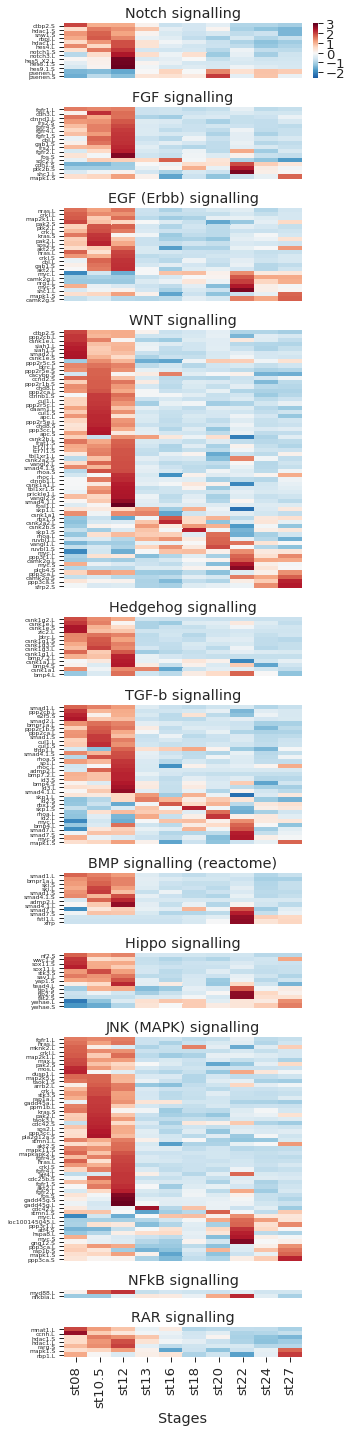

In [51]:
gene_orders = group_heatmap(means, Core_signalling, plot_scaled = True, figure_scale = True, sort_rows = False, 
                            label_size=6, figsize = (5,20))

plt.tight_layout()




In [97]:
for i in gene_orders.keys():
    pd.Series(gene_orders[i]).to_csv('Sup_tables/Heatmap_gene_order/{}_gene_set_order_stages.tsv'.format(i.replace(' ', '_')), sep = '\t')




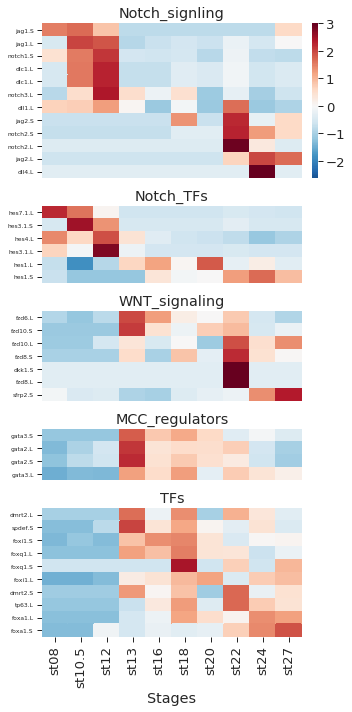

In [171]:
group_heatmap(means, Known_markers, plot_scaled = True, figure_scale = True, sort_rows = True, label_size=6)
plt.tight_layout()
plt.savefig('Heatmap_markers/Known_markers_stages.pdf')




findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


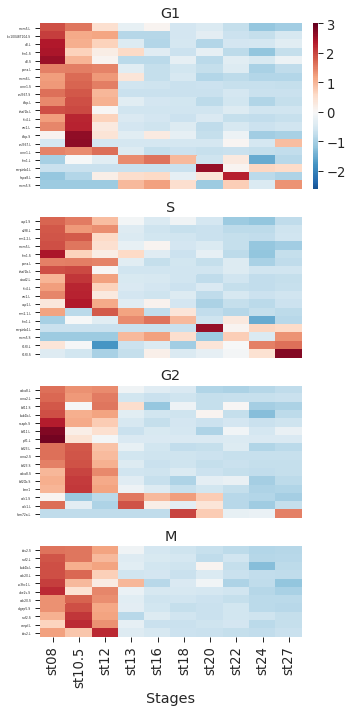

In [82]:
cc_genes, store = group_heatmap(means, CC, plot_scaled = True, human_genes=False, mapper=HtoX, label_size=3)
plt.tight_layout()
#plt.savefig('Heatmap_markers/cyclebase_phase_markers_stages.pdf')


In [83]:
pd.concat(store['G1'], axis = 1).T[pd.concat(store['G1'], axis = 1).T.iloc[:,0].isin(cc_genes['G1'])].to_csv('Heatmap_markers/Gene_lists_bounds/G1_by_stage.tsv', sep = '\t')
pd.concat(store['S'], axis = 1).T[pd.concat(store['S'], axis = 1).T.iloc[:,0].isin(cc_genes['S'])].to_csv('Heatmap_markers/Gene_lists_bounds/S_by_stage.tsv', sep = '\t')
pd.concat(store['G2'], axis = 1).T[pd.concat(store['G2'], axis = 1).T.iloc[:,0].isin(cc_genes['G2'])].to_csv('Heatmap_markers/Gene_lists_bounds/G2_by_stage.tsv', sep = '\t')
pd.concat(store['M'], axis = 1).T[pd.concat(store['M'], axis = 1).T.iloc[:,0].isin(cc_genes['M'])].to_csv('Heatmap_markers/Gene_lists_bounds/M_by_stage.tsv', sep = '\t')



In [100]:
for i in cc_genes.keys():
    pd.Series(cc_genes[i]).to_csv('Sup_tables/Heatmap_gene_order/{}_CC_order_stages.tsv'.format(i.replace(' ', '_')), sep = '\t')


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


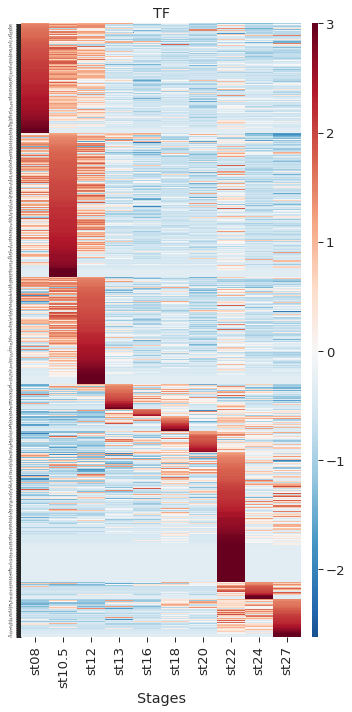

In [31]:
gene_orders, store = group_heatmap(means, TF_db, plot_scaled = True, human_genes=False, mapper=HtoX, label_size=1)

plt.tight_layout()
#plt.savefig('Heatmap_markers/ALL_TFs_AnimalTFDB_stages.pdf')

In [ ]:
gene_orders, store = group_heatmap(means, Core, plot_scaled = True, human_genes=False, mapper=HtoX, label_size=2, figure_scale = False)
plt.savefig('Heatmap_markers/Quigley_core_genes_stages.pdf')



In [146]:
pd.concat(store['MCC core genes'], axis = 1).T[pd.concat(store['MCC core genes'], axis = 1).T.iloc[:,0].isin(gene_orders['MCC core genes'])].to_csv('Heatmap_markers/Gene_lists_bounds/MCC_core_by_stage.tsv', sep = '\t')
pd.concat(store['Ionocyte core genes'], axis = 1).T[pd.concat(store['Ionocyte core genes'], axis = 1).T.iloc[:,0].isin(gene_orders['Ionocyte core genes'])].to_csv('Heatmap_markers/Gene_lists_bounds/Ion_core_by_stage.tsv', sep = '\t')


In [45]:
for i in gene_orders.keys():
    pd.Series(gene_orders[i]).to_csv('Heatmap_markers/{}_gene_set_order_stages.tsv'.format(i.replace(' ', '_')), sep = '\t')



In [66]:
#data = harmony.utils.log_transform(norm_df)
data = norm_df.copy()

In [67]:
data.columns = [x.split('|')[1] for x in data.columns]
data = data.loc[:,~data.columns.duplicated()]

In [68]:
data['cluster'] = clusters
means = data.groupby('cluster').mean().T
order = colors.sort_values('clust_order').org_clust.tolist()

In [ ]:
gene_orders = group_heatmap(means[identifiers[3:]], Core_signalling, plot_scaled = True, figure_scale = True, sort_rows = True, label_size=6)
gene_orders, store = group_heatmap(means, Core_signalling, plot_scaled = True, figure_scale = True, sort_rows = True, 
                            label_size=6, figsize = (5,20), order = order)
plt.savefig('Heatmap_markers/core_signalling_clusters_exp.pdf')



In [88]:
pd.concat(store['Notch signalling'], axis = 1).T[pd.concat(store['Notch signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['Notch signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/Notch_by_cluster.tsv', sep = '\t')
pd.concat(store['WNT signalling'], axis = 1).T[pd.concat(store['WNT signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['WNT signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/WNT_by_cluster.tsv', sep = '\t')
pd.concat(store['TGF-b signalling'], axis = 1).T[pd.concat(store['TGF-b signalling'], axis = 1).T.iloc[:,0].isin(gene_orders['TGF-b signalling'])].to_csv('Heatmap_markers/Gene_lists_bounds/tgfb_by_cluster.tsv', sep = '\t')


In [105]:

for i in gene_orders.keys():
    pd.Series(gene_orders[i]).to_csv('Sup_tables/Heatmap_gene_order/{}_gene_set_order_clusters.tsv'.format(i.replace(' ', '_')), sep = '\t')

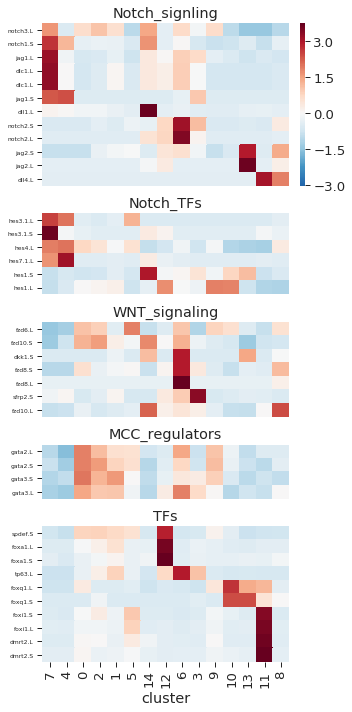

In [177]:

group_heatmap(means, Known_markers, plot_scaled = True, figure_scale = True, sort_rows = True, label_size=6, order = order)
plt.tight_layout()
plt.savefig('Heatmap_markers/Known_markers_clusters.pdf')



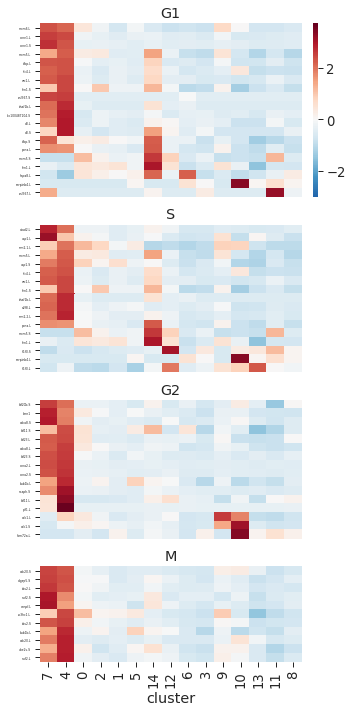

In [89]:
#CC has already been mapped to xenopus gene names
cc_genes, store = group_heatmap(means, CC, plot_scaled = True, human_genes=False, mapper=HtoX, label_size=3, order = order)
plt.tight_layout()
#plt.savefig('Heatmap_markers/cyclebase_phase_markers_clusters.pdf')


In [90]:
pd.concat(store['G1'], axis = 1).T[pd.concat(store['G1'], axis = 1).T.iloc[:,0].isin(cc_genes['G1'])].to_csv('Heatmap_markers/Gene_lists_bounds/G1_by_cluster.tsv', sep = '\t')
pd.concat(store['S'], axis = 1).T[pd.concat(store['S'], axis = 1).T.iloc[:,0].isin(cc_genes['S'])].to_csv('Heatmap_markers/Gene_lists_bounds/S_by_cluster.tsv', sep = '\t')
pd.concat(store['G2'], axis = 1).T[pd.concat(store['G2'], axis = 1).T.iloc[:,0].isin(cc_genes['G2'])].to_csv('Heatmap_markers/Gene_lists_bounds/G2_by_cluster.tsv', sep = '\t')
pd.concat(store['M'], axis = 1).T[pd.concat(store['M'], axis = 1).T.iloc[:,0].isin(cc_genes['M'])].to_csv('Heatmap_markers/Gene_lists_bounds/M_by_cluster.tsv', sep = '\t')



In [107]:
for i in cc_genes.keys():
    pd.Series(cc_genes[i]).to_csv('Sup_tables/Heatmap_gene_order/{}_CC_order_clusters.tsv'.format(i.replace(' ', '_')), sep = '\t')


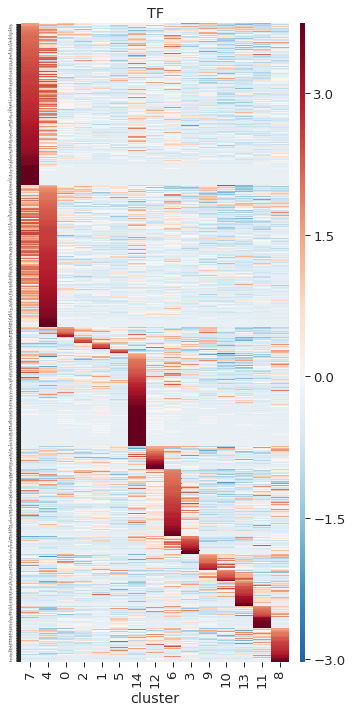

In [34]:
# TF has already been mapped to human gene names
gene_orders = group_heatmap(means, TF_db, plot_scaled = True, human_genes=False, mapper = HtoX, label_size=1, order = order)


plt.tight_layout()
#plt.savefig('Heatmap_markers/ALL_TFs_AnimalTFDB_clusters.pdf')

In [ ]:
gene_orders, store = group_heatmap(means, Core, plot_scaled = True, human_genes=False, mapper=HtoX, label_size=2,  order = order, figure_scale = False)

plt.savefig('Heatmap_markers/Quigley_core_genes_clusters.pdf')





In [156]:
pd.concat(store['MCC core genes'], axis = 1).T[pd.concat(store['MCC core genes'], axis = 1).T.iloc[:,0].isin(gene_orders['MCC core genes'])].to_csv('Heatmap_markers/Gene_lists_bounds/MCC_core_by_cluster.tsv', sep = '\t')
pd.concat(store['Ionocyte core genes'], axis = 1).T[pd.concat(store['Ionocyte core genes'], axis = 1).T.iloc[:,0].isin(gene_orders['Ionocyte core genes'])].to_csv('Heatmap_markers/Gene_lists_bounds/Ion_core_by_cluster.tsv', sep = '\t')


In [109]:
for i in gene_orders.keys():
    pd.Series(gene_orders[i]).to_csv('Sup_tables/Heatmap_gene_order/{}_gene_set_order_clusters.tsv'.format(i.replace(' ', '_')), sep = '\t')
